In [8]:
!pip install --quiet tinydb

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [36]:
%matplotlib inline
from tinydb import TinyDB
import pandas as pd
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

#  Utilities

In [32]:
def num_matching(x, y, two_d_indeces):
    '''
    '''
    return [(x[:,xind].astype(int) + y[:,yind].astype(int) == 2).sum() 
            for xind, yind in zip(two_d_indeces[0], two_d_indeces[1])]  
        
def num_different(x, y, two_d_indeces):
    '''
    '''
    return [(x[:,xind].astype(int) + y[:,yind].astype(int) == 1).sum() \
            for xind, yind in zip(two_d_indeces[0], two_d_indeces[1])]


def get_p_values(x, y, two_d_indeces, test_function):
    '''
    '''
    return [test_function(x[:,xind],y[:,yind]) \
            for xind, yind in zip(two_d_indeces[0],two_d_indeces[1])] 

def get_chi2(x,y):
    '''
    '''
    cross_tab = pd.crosstab(x,y)
    try: 
        cross_tab[0][0] = cross_tab[1][1] 
        return np.round(chi2_contingency(cross_tab)[1],3)
    except Exception:
        return -1

In [12]:
records = TinyDB('db_parsed_drugindication.json').all()
records_pd = pd.DataFrame(records).drop_duplicates()
print('number of unique records', records_pd.shape)

number of unique records (474131, 3)


#  Process data
Convert a collection of reactionmeddrapt and drugindication documents as defined in `https://open.fda.gov/apis/drug/label/searchable-fields` to a matrix of token counts.

In [61]:
tp =r"(?u)[\w -]+"
vectoriser_adverse_effect = CountVectorizer(min_df=5, 
                                            max_df=0.4, 
                                            binary=True, 
                                            token_pattern=tp, 
                                            dtype=np.bool)
matrix_reactionmeddrapt = vectoriser_adverse_effect.fit_transform(records_pd['reactionmeddrapt'])
X_reactionmeddrapt = matrix_reactionmeddrapt.toarray()

vectoriser_drugindication = CountVectorizer(min_df=5, 
                                            max_df=0.4, 
                                            binary=True, 
                                            token_pattern=tp, 
                                            dtype=np.bool)
matrix_drugindication = vectoriser_drugindication.fit_transform(records_pd['drugindication'])
X_drugindication = matrix_drugindication.toarray()

print('Adverse effects count matrix size:', X_reactionmeddrapt.shape, 
      ' Disease indication count matrix size:', X_drugindication.shape)

Adverse effects count matrix size: (474131, 6505)  Disease indication count matrix size: (474131, 2837)


In [24]:
patient_threshold = 5
ind = np.where(X_reactionmeddrapt.sum(1) + X_drugindication.sum(1) > patient_threshold)[0]
adverse_effect = X_reactionmeddrapt[ind,]
disease_area = X_drugindication[ind,]
print('Adverse effects filtered count matrix size:', adverse_effect.shape, 
      ' Disease indication filtered count matrix size:', disease_area.shape)

Adverse effects filtered count matrix size: (82050, 6505)  Disease indication filtered count matrix size: (82050, 2837)


#  Distance metric
Use jaccard distance to compare disease areas and adverse effect

In [25]:
dist = pairwise_distances(adverse_effect.T, disease_area.T, metric='jaccard')

In [30]:
dist_threshold = 0.8
dist_ind = np.where(dist < dist_threshold)
va = vectoriser_adverse_effect.get_feature_names()
vd = vectoriser_drugindication.get_feature_names()
adverse_effect_names = [va[i] for i in dist_ind[0]]
drugindication_names = [vd[i] for i in dist_ind[1]]
results = pd.DataFrame({'disease_areas': drugindication_names,
                       'adverse_effect': adverse_effect_names})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [34]:
results['different'] = num_different(adverse_effect, disease_area, dist_ind)
results['matched'] = num_matching(adverse_effect, disease_area, dist_ind)
results['chi2'] = get_p_values(adverse_effect, disease_area, dist_ind, get_chi2)

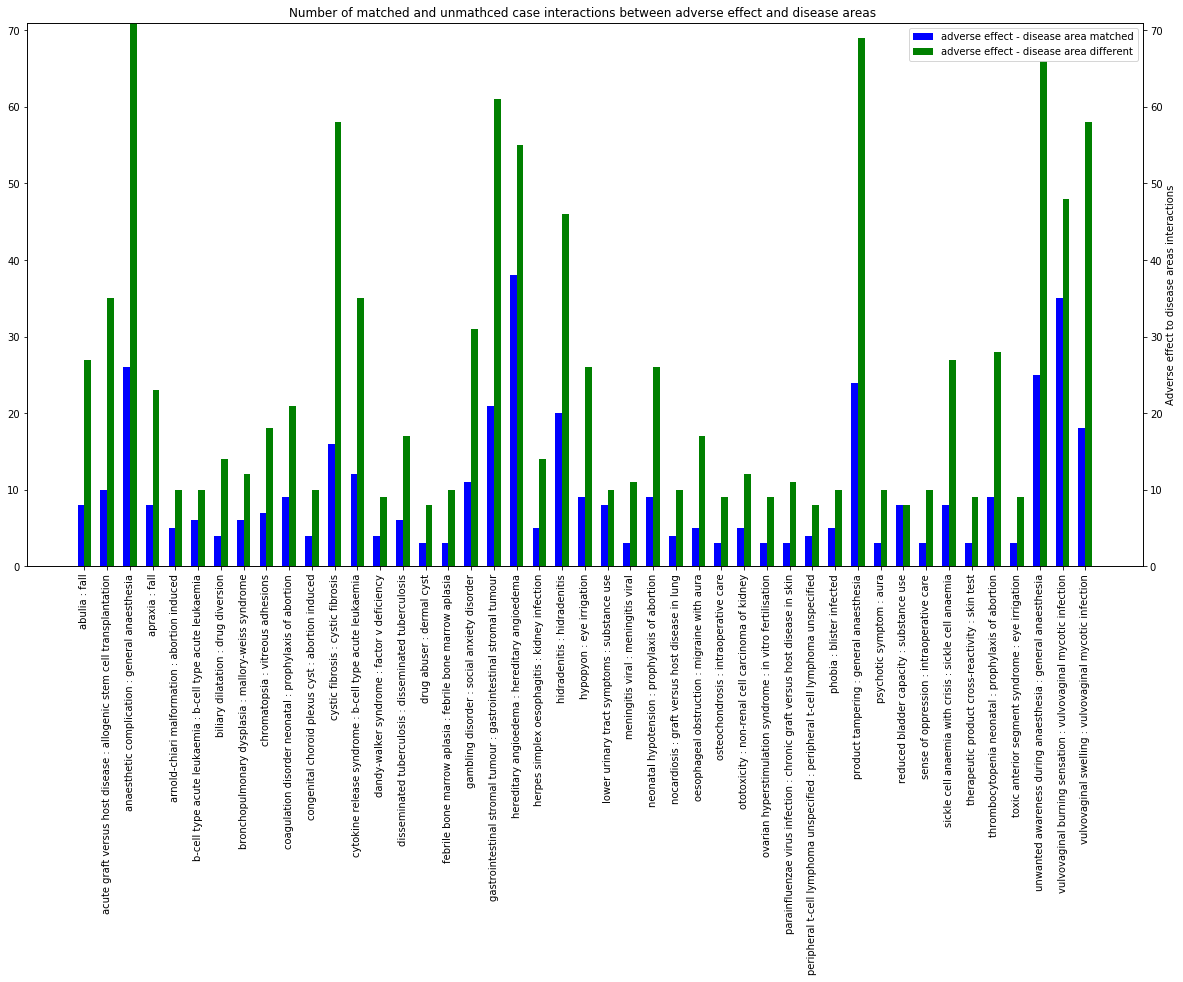

In [62]:
results_filt = results[(results['different']+results['matched']>10)]
results_filt = results_filt[(results_filt['different']+results_filt['matched']<100)]
plt.figure(figsize=(20,10))
x = np.arange(results_filt.shape[0])
ax1 = plt.subplot(1,1,1)
ax1.set_title('Number of matched and unmathced case interactions between adverse effect and disease areas ')
w = 0.3
n = max(results_filt['different'].max(),results_filt['matched'].max())
plt.xticks(x + w /2, results_filt['adverse_effect'] +' : '+results_filt['disease_areas'], rotation='vertical')
pop =ax1.bar(x, results_filt['matched'], width=w, color='b', align='center')
ax1.set_ylim(0,n)
ax2 = ax1.twinx()
ax2.set_ylim(0,n)
gdp =ax2.bar(x + w, results_filt['different'], width=w,color='g',align='center')
plt.ylabel('Counts')
plt.ylabel('Adverse effect to disease areas interactions')
plt.legend([pop, gdp],['adverse effect - disease area matched', 'adverse effect - disease area different'])
plt.show()

# Results
We find some interesting but also expected observations:
- Breast cancer treatment leads to hair loss
- Attention deficit correlate with gynaecomastia adverse effect 
- Treatment of alopecia leads correlate with sexual dysfunction adverse effect 
- Sometimes disease areas and adverse effects are the same, this could be by-product of multi-drug multi-disease cases 


In [67]:
results[results.matched>7]

,disease_areas,adverse_effect,different,matched,chi2
0,fall,abulia,27,8,0.178
1,allogenic stem cell transplantation,acute graft versus host disease,35,10,0.110
9,general anaesthesia,anaesthetic complication,71,26,0.685
16,fall,apraxia,23,8,0.425
43,prophylaxis of abortion,coagulation disorder neonatal,21,9,0.634
50,crohn,crohn,1669,438,0.385
51,cystic fibrosis,cystic fibrosis,58,16,0.730
52,b-cell type acute leukaemia,cytokine release syndrome,35,12,0.916
65,blood testosterone decreased,economic problem,532,185,0.000
82,social anxiety disorder,gambling disorder,31,11,0.578


In [68]:
results.to_csv('disease_areas_to_adverse_effect.csv')

In [65]:
temp = results.groupby(['disease_areas'])['adverse_effect'].describe()
temp[temp['count']>1]

,count,unique,top,freq
disease_areas,,,,
abortion induced,2,2,arnold-chiari malformation,1
aneurysm,2,2,peripheral artery aneurysm,1
asymptomatic hiv infection,2,2,amniotic band syndrome,1
b-cell type acute leukaemia,2,2,cytokine release syndrome,1
breast cancer female,3,3,hair disorder,1
cerebellar infarction,3,3,embolic cerebral infarction,1
colorectal cancer recurrent,2,2,postoperative abscess,1
congenital retinoblastoma,2,2,retinal pigment epitheliopathy,1
dermal cyst,2,2,drug abuser,1


In [66]:
temp = results.groupby(['adverse_effect'])['disease_areas'].describe()
temp[temp['count']>1]

,count,unique,top,freq
adverse_effect,,,,
adactyly,2,2,fallot,1
angiocentric lymphoma,2,2,reiter,1
blastomycosis,2,2,abdominal abscess,1
corneal deposits,2,2,keratoconus,1
drug cross-reactivity,2,2,heparin-induced thrombocytopenia,1
encephalitis cytomegalovirus,2,2,meningitis viral,1
erythropoiesis abnormal,2,2,lymphoplasmacytoid lymphoma,1
foetal exposure timing unspecified,2,2,cerebellar infarction,1
gynaecomastia,2,2,attention deficit,1
